# IMPORT MODULES & FUNCTIONS

In [8]:
#IMPORT PACKAGES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pytz #for timezone calculation
import math
import matplotlib.dates as md
import gc
import os
from datetime import datetime
import calendar
import seaborn as sns; sns.set()
import itertools
#import datetime
from time import gmtime, strftime
from matplotlib import cm
from IPython.display import display
#%matplotlib qt
#%matplotlib inline

#SET GLOBAL PARAMETERS
# ================== Global parameters for fonts & sizes =================
FONT_SIZE = 20
rc={'font.size': FONT_SIZE, 'axes.labelsize': FONT_SIZE, 'legend.fontsize': FONT_SIZE, 
    'axes.titlesize': FONT_SIZE, 'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
plt.rcParams.update(**rc)
plt.rc('font', weight='bold')
 
# For label titles
fontdict={'fontsize': FONT_SIZE, 'fontweight' : 'bold'}
# can add in above dictionary: 'verticalalignment': 'baseline' 

style = 'ggplot' # choose a style from the above options
plt.style.use(style)

from solarcurtailment.energy_calculation import *
from solarcurtailment.clear_sky_day import *
from solarcurtailment.tripping_curt import *
from solarcurtailment.vvar_curt import *
from solarcurtailment.vwatt_curt import *
from solarcurtailment.polyfit import *
from solarcurtailment.file_processing import *
from solarcurtailment.data_visualization import *

#Remove unnecessary warning
pd.options.mode.chained_assignment = None  # default='warn'
np.warnings.filterwarnings('ignore')

#class instantiation
file_processing = FileProcessing()
clear_sky_day = ClearSkyDay()
data_visualization = DataVisualization()
energy_calculation = EnergyCalculation()
tripping_curt = TrippingCurt()
polyfit_f = Polyfit()
vvar_curt = VVarCurt()
vwatt_curt = VWattCurt()

#from FileProcessing 
def input_monthly_files(file_path, data_date_idx):
    """Open time-series D-PV data and ghi data of a certain month. Only compatible for SoLA data format.

    Args:
        file_path (str): The file location of the data
        data_date_idx (str): The month of the files in format 'YYYYMM' eg '201907'

    Returns:
        data (df): the opened & cleaned time-series D-PV data
        ghi (df): the opened & cleaned ghi data
        data_ori (df): the opened & unmodified time-series D-PV data
        ghi_ori (df): the opened & unmodified ghi data
    """
    
    data_path = file_path + r"/processed_unsw_" + data_date_idx + '_data_raw.csv'
    data_ori = pd.read_csv(data_path)
    data = data_ori.set_index('utc_tstamp')

    # Convert timestamp to local Adelaide time
    data.index = pd.to_datetime(data.index) # convert index from object type to datetime
    Adelaide_local_time = pytz.timezone('Australia/Adelaide')
    data.index = data.index.tz_localize(pytz.utc).tz_convert(Adelaide_local_time) # convert utc to local adelaide time
    data.index.rename('Timestamp', inplace = True)

    # Load GHI data
    ghi_date_idx = data_date_idx[0:4] + '_' + data_date_idx[4:]
    ghi_path = file_path + r"/sl_023034_" + ghi_date_idx +'.txt'
    ghi = pd.read_csv (ghi_path) 
    ghi_ori = ghi.copy()

    ghi['timestamp'] = pd.to_datetime(pd.DataFrame ({'year' : ghi['Year Month Day Hours Minutes in YYYY'].values, 
                                                    'month' : ghi['MM'], 
                                                    'day' : ghi['DD'], 
                                                   'hour' : ghi['HH24'], 
                                                   'minute' : ghi['MI format in Local standard time']}))
    ghi.set_index('timestamp', inplace = True)
    # Deal with the space characters (ghi is in object/string form at the moment)
    ghi['Mean global irradiance (over 1 minute) in W/sq m'] = [float(ghi_t) if ghi_t.count(' ')<= 3 else np.nan for ghi_t in ghi['Mean global irradiance (over 1 minute) in W/sq m']]
    
    return data, ghi, data_ori, ghi_ori

# CHECK ALL DAYS
Find list of all dates which data are available

In [2]:
def create_date_list(year, month, num_of_days):
    """Create a list of date as str for certain month and year.

    Args:
        year (str): year
        month (str): month
        num_of_days (int): number of days for a certain month and year. 

    Returns:
        date_list (list): list of date as str
    """
    
    date_list = []
    
    for i in range(1, 10):
        date_list.append(year + '-' + month + '-0'  + str(i))
    for i in range(10, num_of_days + 1):
        date_list.append(year + '-' + month + '-'  + str(i))
    
    return date_list

In [3]:
datelist_201907 = create_date_list('2019', '07', 31)
datelist_201908 = create_date_list('2019', '08', 31)
datelist_201909 = create_date_list('2019', '09', 30)
datelist_201910 = create_date_list('2019', '10', 31)
datelist_201911 = create_date_list('2019', '11', 30)
datelist_201912 = create_date_list('2019', '12', 31)
datelist_202001 = create_date_list('2020', '01', 31)
datelist_202002 = create_date_list('2020', '02', 29)
datelist_202003 = create_date_list('2020', '03', 31)
datelist_202004 = create_date_list('2020', '04', 30)


date_list = datelist_201907 + datelist_201908 + datelist_201909 + datelist_201910 + datelist_201911 + datelist_201912 + datelist_202001 + datelist_202002 + datelist_202003 + datelist_202004

# CLEAR SKY DAYS LIST

In [4]:
csd_201907 = ['2019-07-09', '2019-07-19', '2019-07-20']
csd_201908 = ['2019-08-05', '2019-08-14', '2019-08-23', '2019-08-26', '2019-08-30']
csd_201909 = ['2019-09-12', '2019-09-17', '2019-09-18', '2019-09-26', '2019-09-29', '2019-09-30']
csd_201910 = ['2019-10-01', '2019-10-02', '2019-10-03', '2019-10-29']
csd_201911 = ['2019-11-18', '2019-11-27']
csd_201912 = ['2019-12-16', '2019-12-19', '2019-12-25', '2019-12-28']
csd_202001 = ['2020-01-01', '2020-01-02', '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-12', '2020-01-13', '2020-01-14', '2020-01-17', '2020-01-29', '2020-01-30']
csd_202002 = ['2020-02-04', '2020-02-05', '2020-02-06', '2020-02-10', '2020-02-11', '2020-02-13', '2020-02-22', '2020-02-23']
csd_202003 = ['2020-03-03', '2020-03-08', '2020-03-10', '2020-03-14', '2020-03-15', '2020-03-25', '2020-03-26']
csd_202004 = ['2020-04-08', '2020-04-09', '2020-04-13', '2020-04-24']

csd_list = csd_201907 + csd_201908 + csd_201909 + csd_201910 + csd_201911 + csd_201912 + csd_202001 + csd_202002 + csd_202003 + csd_202004

# INPUT ALL MONTHLY DATA & GENERAL FILES

In [11]:
file_path = r"/Users/samhan/Downloads/data" #for running in Samhan's laptop
#file_path = r"C:\Users\samha\Documents\CANVAS\data" #for running in TETB CEEM09 computer

In [6]:


month_list = ['201907', '201908', '201909', '201910', '201911', '201912', '202001', '202002', '202003', '202004']
data = {}
data_ori = {}
ghi = {}
ghi_ori = {}
for month in month_list:
    print('processing {} ...'.format(month))
    data[month], ghi[month], data_ori[month], ghi_ori[month] = input_monthly_files(file_path, month)
    data[month]['date'] = data[month].index.date
    
site_details, unique_cids= file_processing.input_general_files(file_path)

processing 201909 ...
processing 201910 ...
processing 201911 ...
processing 201912 ...
processing 202001 ...
processing 202002 ...
processing 202003 ...
processing 202004 ...


In [116]:
#DELETE LATER
month_list = ['201907', '201908']
for month in month_list:
    print('processing {} ...'.format(month))
    data[month], ghi[month], data_ori[month], ghi_ori[month] = input_monthly_files(file_path, month)
    data[month]['date'] = data[month].index.date

processing 201907 ...
processing 201908 ...


# DIVIDE THE COMPUTATION INTO 5 BATCH, 100 SITES PER BATCH

In [166]:
c_id_batch_1 = unique_cids['c_id'][:100]
c_id_batch_2 = unique_cids['c_id'][100:200]
c_id_batch_3 = unique_cids['c_id'][200:300]
c_id_batch_4 = unique_cids['c_id'][300:400]
c_id_batch_5 = unique_cids['c_id'][400:500]

# LOOP FOR 10 MONTHS FOR CSD

# BATCH 1

In [204]:
batch = 1

In [205]:
summary = pd.DataFrame()
date_not_analyzed = []
date_successfully_analyzed = []
site_number = 1

for c_id in c_id_batch_1:
    print('Analyzing site {} of 100 sites, c_id {}'.format(site_number, c_id))
    site_number += 1
    
    last_month_analyzed = 201907
    last_cid_analyzed = 0
    count_curtailment = 0
    total_energy_generation = 0
    total_tripping_curtailment = 0
    for date in csd_list: 
#         print('Analyzing c_id {} date {} ...'.format(c_id, date))
        
        #filter D-PV time series data
        date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
        month_analyzed = date[:4] + date [5:7]
#         print('Analyzing c_id {} month {} ...'.format(c_id, month_analyzed))
        
        if not month_analyzed == last_month_analyzed:
            site_id_filter = data[month_analyzed]['c_id'] == c_id
            data_certain_site = data[month_analyzed].loc[site_id_filter]
            last_month_analyzed = month_analyzed
            
        date_filter = data_certain_site['date'] == date_dt
        data_analyzed = data_certain_site.loc[date_filter]
        data_analyzed = data_analyzed.sort_index(ascending=True)

        #check tripping curtailment
        ac_cap = int(site_details.loc[site_details['c_id'] == c_id, 'ac_cap_w'])
        size_is_ok = file_processing.check_data_size(data_analyzed, ac_cap)
        
        if not size_is_ok:
#             print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
            date_not_analyzed.append(date)
#             data_analyzed['power'].plot()
#             plt.show()
        else:
            date_successfully_analyzed.append(date)
            data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
            data_site = file_processing.resample_in_minute(data_site)
            
            if date in csd_list:
                is_clear_sky_day = True
            else:
                is_clear_sky_day = False
            
            tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
            energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)
            
            total_energy_generation += energy_generated
            
            if tripping_curt_energy > 0:
                count_curtailment += 1
                total_tripping_curtailment += tripping_curt_energy
    
    #summarize result
    c_id_summary = pd.DataFrame({
            'c_id' : [c_id],
            'total_energy_generation (kWh)' : [total_energy_generation],
            'total_tripping_curtailment (kWh)' : [total_tripping_curtailment],
            'count curtailment (days)' : [count_curtailment],
            'total days (days)' : [len(csd_list)]
        })
    
    summary = pd.concat([summary, c_id_summary])

summary.to_csv(file_path + r'/tripping_csd_{}.csv'.format(batch), index = False) 

Analyzing site 1 of 100 sites, c_id 1700492033
Analyzing site 2 of 100 sites, c_id 1146549788
Analyzing site 3 of 100 sites, c_id 1027250881
Analyzing site 4 of 100 sites, c_id 389622988
Analyzing site 5 of 100 sites, c_id 1363592770
Analyzing site 6 of 100 sites, c_id 1814154495
Analyzing site 7 of 100 sites, c_id 920290771
Analyzing site 8 of 100 sites, c_id 825500746
Analyzing site 9 of 100 sites, c_id 1864193631
Analyzing site 10 of 100 sites, c_id 1173628499
Analyzing site 11 of 100 sites, c_id 684163813
Analyzing site 12 of 100 sites, c_id 440658205
Analyzing site 13 of 100 sites, c_id 594232181
Analyzing site 14 of 100 sites, c_id 1288089120
Analyzing site 15 of 100 sites, c_id 2084803628
Analyzing site 16 of 100 sites, c_id 1561543809
Analyzing site 17 of 100 sites, c_id 1648066113
Analyzing site 18 of 100 sites, c_id 1326376829
Analyzing site 19 of 100 sites, c_id 960184009
Analyzing site 20 of 100 sites, c_id 1276618490
Analyzing site 21 of 100 sites, c_id 948674318
Analyzing

# BATCH 2

In [206]:
batch = 2

In [208]:
summary = pd.DataFrame()
date_not_analyzed = []
date_successfully_analyzed = []
site_number = 1

for c_id in c_id_batch_2:
    print('Analyzing site {} of 100 sites, c_id {}'.format(site_number, c_id))
    site_number += 1
    
    last_month_analyzed = 201907
    last_cid_analyzed = 0
    count_curtailment = 0
    total_energy_generation = 0
    total_tripping_curtailment = 0
    for date in csd_list: 
#         print('Analyzing c_id {} date {} ...'.format(c_id, date))
        
        #filter D-PV time series data
        date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
        month_analyzed = date[:4] + date [5:7]
#         print('Analyzing c_id {} month {} ...'.format(c_id, month_analyzed))
        
        if not month_analyzed == last_month_analyzed:
            site_id_filter = data[month_analyzed]['c_id'] == c_id
            data_certain_site = data[month_analyzed].loc[site_id_filter]
            last_month_analyzed = month_analyzed
            
        date_filter = data_certain_site['date'] == date_dt
        data_analyzed = data_certain_site.loc[date_filter]
        data_analyzed = data_analyzed.sort_index(ascending=True)

        #check tripping curtailment
        ac_cap = int(site_details.loc[site_details['c_id'] == c_id, 'ac_cap_w'])
        size_is_ok = file_processing.check_data_size(data_analyzed, ac_cap)
        
        if not size_is_ok:
#             print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
            date_not_analyzed.append(date)
#             data_analyzed['power'].plot()
#             plt.show()
        else:
            date_successfully_analyzed.append(date)
            data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
            data_site = file_processing.resample_in_minute(data_site)
            
            if date in csd_list:
                is_clear_sky_day = True
            else:
                is_clear_sky_day = False
            
            tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
            energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)
            
            total_energy_generation += energy_generated
            
            if tripping_curt_energy > 0:
                count_curtailment += 1
                total_tripping_curtailment += tripping_curt_energy
    
    #summarize result
    c_id_summary = pd.DataFrame({
            'c_id' : [c_id],
            'total_energy_generation (kWh)' : [total_energy_generation],
            'total_tripping_curtailment (kWh)' : [total_tripping_curtailment],
            'count curtailment (days)' : [count_curtailment],
            'total days (days)' : [len(csd_list)]
        })
    
    summary = pd.concat([summary, c_id_summary])

summary.to_csv(file_path + r'/tripping_csd_{}.csv'.format(batch), index = False) 

Analyzing site 1 of 100 sites, c_id 1765463917
Analyzing site 2 of 100 sites, c_id 362641176
Analyzing site 3 of 100 sites, c_id 501296684
Analyzing site 4 of 100 sites, c_id 728603657
Analyzing site 5 of 100 sites, c_id 1754502986
Analyzing site 6 of 100 sites, c_id 671978489
Analyzing site 7 of 100 sites, c_id 977227615
Analyzing site 8 of 100 sites, c_id 576609445



KeyboardInterrupt



# BATCH 3

In [ ]:
batch = 3

In [ ]:
summary = pd.DataFrame()
date_not_analyzed = []
date_successfully_analyzed = []
site_number = 1

for c_id in c_id_batch_3: 
    print('Analyzing site {} of 100 sites, c_id {}'.format(site_number, c_id))
    site_number += 1
    
    last_month_analyzed = 201907
    last_cid_analyzed = 0
    count_curtailment = 0
    total_energy_generation = 0
    total_tripping_curtailment = 0
    for date in csd_list: 
#         print('Analyzing c_id {} date {} ...'.format(c_id, date))
        
        #filter D-PV time series data
        date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
        month_analyzed = date[:4] + date [5:7]
#         print('Analyzing c_id {} month {} ...'.format(c_id, month_analyzed))
        
        if not month_analyzed == last_month_analyzed:
            site_id_filter = data[month_analyzed]['c_id'] == c_id
            data_certain_site = data[month_analyzed].loc[site_id_filter]
            last_month_analyzed = month_analyzed
            
        date_filter = data_certain_site['date'] == date_dt
        data_analyzed = data_certain_site.loc[date_filter]
        data_analyzed = data_analyzed.sort_index(ascending=True)

        #check tripping curtailment
        ac_cap = int(site_details.loc[site_details['c_id'] == c_id, 'ac_cap_w'])
        size_is_ok = file_processing.check_data_size(data_analyzed, ac_cap)
        
        if not size_is_ok:
#             print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
            date_not_analyzed.append(date)
#             data_analyzed['power'].plot()
#             plt.show()
        else:
            date_successfully_analyzed.append(date)
            data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
            data_site = file_processing.resample_in_minute(data_site)
            
            if date in csd_list:
                is_clear_sky_day = True
            else:
                is_clear_sky_day = False
            
            tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
            energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)
            
            total_energy_generation += energy_generated
            
            if tripping_curt_energy > 0:
                count_curtailment += 1
                total_tripping_curtailment += tripping_curt_energy
    
    #summarize result
    c_id_summary = pd.DataFrame({
            'c_id' : [c_id],
            'total_energy_generation (kWh)' : [total_energy_generation],
            'total_tripping_curtailment (kWh)' : [total_tripping_curtailment],
            'count curtailment (days)' : [count_curtailment],
            'total days (days)' : [len(csd_list)]
        })
    
    summary = pd.concat([summary, c_id_summary])

summary.to_csv(file_path + r'/tripping_csd_{}.csv'.format(batch), index = False) 

# BATCH 4

In [ ]:
batch = 4

In [ ]:
summary = pd.DataFrame()
date_not_analyzed = []
date_successfully_analyzed = []
site_number = 1

for c_id in c_id_batch_4: 
    print('Analyzing site {} of 100 sites, c_id {}'.format(site_number, c_id))
    site_number += 1
    
    last_month_analyzed = 201907
    last_cid_analyzed = 0
    count_curtailment = 0
    total_energy_generation = 0
    total_tripping_curtailment = 0
    for date in csd_list: 
#         print('Analyzing c_id {} date {} ...'.format(c_id, date))
        
        #filter D-PV time series data
        date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
        month_analyzed = date[:4] + date [5:7]
#         print('Analyzing c_id {} month {} ...'.format(c_id, month_analyzed))
        
        if not month_analyzed == last_month_analyzed:
            site_id_filter = data[month_analyzed]['c_id'] == c_id
            data_certain_site = data[month_analyzed].loc[site_id_filter]
            last_month_analyzed = month_analyzed
            
        date_filter = data_certain_site['date'] == date_dt
        data_analyzed = data_certain_site.loc[date_filter]
        data_analyzed = data_analyzed.sort_index(ascending=True)

        #check tripping curtailment
        ac_cap = int(site_details.loc[site_details['c_id'] == c_id, 'ac_cap_w'])
        size_is_ok = file_processing.check_data_size(data_analyzed, ac_cap)
        
        if not size_is_ok:
#             print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
            date_not_analyzed.append(date)
#             data_analyzed['power'].plot()
#             plt.show()
        else:
            date_successfully_analyzed.append(date)
            data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
            data_site = file_processing.resample_in_minute(data_site)
            
            if date in csd_list:
                is_clear_sky_day = True
            else:
                is_clear_sky_day = False
            
            tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
            energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)
            
            total_energy_generation += energy_generated
            
            if tripping_curt_energy > 0:
                count_curtailment += 1
                total_tripping_curtailment += tripping_curt_energy
    
    #summarize result
    c_id_summary = pd.DataFrame({
            'c_id' : [c_id],
            'total_energy_generation (kWh)' : [total_energy_generation],
            'total_tripping_curtailment (kWh)' : [total_tripping_curtailment],
            'count curtailment (days)' : [count_curtailment],
            'total days (days)' : [len(csd_list)]
        })
    
    summary = pd.concat([summary, c_id_summary])

summary.to_csv(file_path + r'/tripping_csd_{}.csv'.format(batch), index = False) 

# BATCH 5

In [ ]:
batch = 5

In [ ]:
summary = pd.DataFrame()
date_not_analyzed = []
date_successfully_analyzed = []
site_number = 1

for c_id in c_id_batch_5: 
    print('Analyzing site {} of 100 sites, c_id {}'.format(site_number, c_id))
    site_number += 1
    
    last_month_analyzed = 201907
    last_cid_analyzed = 0
    count_curtailment = 0
    total_energy_generation = 0
    total_tripping_curtailment = 0
    for date in csd_list: 
#         print('Analyzing c_id {} date {} ...'.format(c_id, date))
        
        #filter D-PV time series data
        date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
        month_analyzed = date[:4] + date [5:7]
#         print('Analyzing c_id {} month {} ...'.format(c_id, month_analyzed))
        
        if not month_analyzed == last_month_analyzed:
            site_id_filter = data[month_analyzed]['c_id'] == c_id
            data_certain_site = data[month_analyzed].loc[site_id_filter]
            last_month_analyzed = month_analyzed
            
        date_filter = data_certain_site['date'] == date_dt
        data_analyzed = data_certain_site.loc[date_filter]
        data_analyzed = data_analyzed.sort_index(ascending=True)

        #check tripping curtailment
        ac_cap = int(site_details.loc[site_details['c_id'] == c_id, 'ac_cap_w'])
        size_is_ok = file_processing.check_data_size(data_analyzed, ac_cap)
        
        if not size_is_ok:
#             print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
            date_not_analyzed.append(date)
#             data_analyzed['power'].plot()
#             plt.show()
        else:
            date_successfully_analyzed.append(date)
            data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
            data_site = file_processing.resample_in_minute(data_site)
            
            if date in csd_list:
                is_clear_sky_day = True
            else:
                is_clear_sky_day = False
            
            tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
            energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)
            
            total_energy_generation += energy_generated
            
            if tripping_curt_energy > 0:
                count_curtailment += 1
                total_tripping_curtailment += tripping_curt_energy
    
    #summarize result
    c_id_summary = pd.DataFrame({
            'c_id' : [c_id],
            'total_energy_generation (kWh)' : [total_energy_generation],
            'total_tripping_curtailment (kWh)' : [total_tripping_curtailment],
            'count curtailment (days)' : [count_curtailment],
            'total days (days)' : [len(csd_list)]
        })
    
    summary = pd.concat([summary, c_id_summary])

summary.to_csv(file_path + r'/tripping_csd_{}.csv'.format(batch), index = False) 

# LOOP FOR 10 MONTHS FOR ALL DAYS

# BATCH 1

In [220]:
batch = 1

In [221]:
summary = pd.DataFrame()
date_not_analyzed = []
date_successfully_analyzed = []
site_number = 1

for c_id in c_id_batch_1: 
    print('Analyzing site {} of 100 sites, c_id {}'.format(site_number, c_id))
    site_number += 1
    
    last_month_analyzed = 201907
    last_cid_analyzed = 0
    count_curtailment = 0
    total_energy_generation = 0
    total_tripping_curtailment = 0
    for date in date_list: 
#         print('Analyzing c_id {} date {} ...'.format(c_id, date))
        
        #filter D-PV time series data
        date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
        month_analyzed = date[:4] + date [5:7]
#         print('Analyzing c_id {} month {} ...'.format(c_id, month_analyzed))
        
        if not month_analyzed == last_month_analyzed:
            site_id_filter = data[month_analyzed]['c_id'] == c_id
            data_certain_site = data[month_analyzed].loc[site_id_filter]
            last_month_analyzed = month_analyzed
            
        date_filter = data_certain_site['date'] == date_dt
        data_analyzed = data_certain_site.loc[date_filter]
        data_analyzed = data_analyzed.sort_index(ascending=True)

        #check tripping curtailment
        ac_cap = int(site_details.loc[site_details['c_id'] == c_id, 'ac_cap_w'])
        size_is_ok = file_processing.check_data_size(data_analyzed, ac_cap)
        
        if not size_is_ok:
#             print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
            date_not_analyzed.append(date)
#             data_analyzed['power'].plot()
#             plt.show()
        else:
            date_successfully_analyzed.append(date)
            data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
            data_site = file_processing.resample_in_minute(data_site)
            
            if date in csd_list:
                is_clear_sky_day = True
            else:
                is_clear_sky_day = False
            
            tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
            energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)
            
            total_energy_generation += energy_generated
            
            if tripping_curt_energy > 0:
                count_curtailment += 1
                total_tripping_curtailment += tripping_curt_energy
    
    #summarize result
    c_id_summary = pd.DataFrame({
            'c_id' : [c_id],
            'total_energy_generation (kWh)' : [total_energy_generation],
            'total_tripping_curtailment (kWh)' : [total_tripping_curtailment],
            'count curtailment (days)' : [count_curtailment],
            'total days (days)' : [len(date_list)]
        })
    
    summary = pd.concat([summary, c_id_summary])

summary.to_csv(file_path + r'/tripping_alldays_{}.csv'.format(batch), index = False) 

Analyzing site 1 of 100 sites, c_id 1700492033
Analyzing site 2 of 100 sites, c_id 1146549788
Analyzing site 3 of 100 sites, c_id 1027250881
Analyzing site 4 of 100 sites, c_id 389622988
Analyzing site 5 of 100 sites, c_id 1363592770
Analyzing site 6 of 100 sites, c_id 1814154495
Analyzing site 7 of 100 sites, c_id 920290771
Analyzing site 8 of 100 sites, c_id 825500746
Analyzing site 9 of 100 sites, c_id 1864193631
Analyzing site 10 of 100 sites, c_id 1173628499
Analyzing site 11 of 100 sites, c_id 684163813
Analyzing site 12 of 100 sites, c_id 440658205
Analyzing site 13 of 100 sites, c_id 594232181
Analyzing site 14 of 100 sites, c_id 1288089120
Analyzing site 15 of 100 sites, c_id 2084803628
Analyzing site 16 of 100 sites, c_id 1561543809
Analyzing site 17 of 100 sites, c_id 1648066113
Analyzing site 18 of 100 sites, c_id 1326376829
Analyzing site 19 of 100 sites, c_id 960184009
Analyzing site 20 of 100 sites, c_id 1276618490
Analyzing site 21 of 100 sites, c_id 948674318
Analyzing

# BATCH 2

In [210]:
batch = 2

In [211]:
summary = pd.DataFrame()
date_not_analyzed = []
date_successfully_analyzed = []
site_number = 1

for c_id in c_id_batch_2: 
    print('Analyzing site {} of 100 sites, c_id {}'.format(site_number, c_id))
    site_number += 1
    
    last_month_analyzed = 201907
    last_cid_analyzed = 0
    count_curtailment = 0
    total_energy_generation = 0
    total_tripping_curtailment = 0
    for date in date_list: 
#         print('Analyzing c_id {} date {} ...'.format(c_id, date))
        
        #filter D-PV time series data
        date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
        month_analyzed = date[:4] + date [5:7]
#         print('Analyzing c_id {} month {} ...'.format(c_id, month_analyzed))
        
        if not month_analyzed == last_month_analyzed:
            site_id_filter = data[month_analyzed]['c_id'] == c_id
            data_certain_site = data[month_analyzed].loc[site_id_filter]
            last_month_analyzed = month_analyzed
            
        date_filter = data_certain_site['date'] == date_dt
        data_analyzed = data_certain_site.loc[date_filter]
        data_analyzed = data_analyzed.sort_index(ascending=True)

        #check tripping curtailment
        ac_cap = int(site_details.loc[site_details['c_id'] == c_id, 'ac_cap_w'])
        size_is_ok = file_processing.check_data_size(data_analyzed, ac_cap)
        
        if not size_is_ok:
#             print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
            date_not_analyzed.append(date)
#             data_analyzed['power'].plot()
#             plt.show()
        else:
            date_successfully_analyzed.append(date)
            data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
            data_site = file_processing.resample_in_minute(data_site)
            
            if date in csd_list:
                is_clear_sky_day = True
            else:
                is_clear_sky_day = False
            
            tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
            energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)
            
            total_energy_generation += energy_generated
            
            if tripping_curt_energy > 0:
                count_curtailment += 1
                total_tripping_curtailment += tripping_curt_energy
    
    #summarize result
    c_id_summary = pd.DataFrame({
            'c_id' : [c_id],
            'total_energy_generation (kWh)' : [total_energy_generation],
            'total_tripping_curtailment (kWh)' : [total_tripping_curtailment],
            'count curtailment (days)' : [count_curtailment],
            'total days (days)' : [len(date_list)]
        })
    
    summary = pd.concat([summary, c_id_summary])

summary.to_csv(file_path + r'/tripping_alldays_{}.csv'.format(batch), index = False) 

Analyzing site 1 of 100 sites, c_id 1765463917
Analyzing site 2 of 100 sites, c_id 362641176
Analyzing site 3 of 100 sites, c_id 501296684
Analyzing site 4 of 100 sites, c_id 728603657
Analyzing site 5 of 100 sites, c_id 1754502986
Analyzing site 6 of 100 sites, c_id 671978489
Analyzing site 7 of 100 sites, c_id 977227615
Analyzing site 8 of 100 sites, c_id 576609445
Analyzing site 9 of 100 sites, c_id 1822597721
Analyzing site 10 of 100 sites, c_id 849091584
Analyzing site 11 of 100 sites, c_id 466930914
Analyzing site 12 of 100 sites, c_id 1836936064
Analyzing site 13 of 100 sites, c_id 1909120217
Analyzing site 14 of 100 sites, c_id 982512371
Analyzing site 15 of 100 sites, c_id 401305664
Analyzing site 16 of 100 sites, c_id 1203715542
Analyzing site 17 of 100 sites, c_id 1599337672
Analyzing site 18 of 100 sites, c_id 811944521
Analyzing site 19 of 100 sites, c_id 467236422
Analyzing site 20 of 100 sites, c_id 1706723726
Analyzing site 21 of 100 sites, c_id 1713456246
Analyzing sit

# BATCH 3

In [212]:
batch = 3

In [213]:
summary = pd.DataFrame()
date_not_analyzed = []
date_successfully_analyzed = []
site_number = 1

for c_id in c_id_batch_3: 
    print('Analyzing site {} of 100 sites, c_id {}'.format(site_number, c_id))
    site_number += 1
    
    last_month_analyzed = 201907
    last_cid_analyzed = 0
    count_curtailment = 0
    total_energy_generation = 0
    total_tripping_curtailment = 0
    for date in date_list: 
#         print('Analyzing c_id {} date {} ...'.format(c_id, date))
        
        #filter D-PV time series data
        date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
        month_analyzed = date[:4] + date [5:7]
#         print('Analyzing c_id {} month {} ...'.format(c_id, month_analyzed))
        
        if not month_analyzed == last_month_analyzed:
            site_id_filter = data[month_analyzed]['c_id'] == c_id
            data_certain_site = data[month_analyzed].loc[site_id_filter]
            last_month_analyzed = month_analyzed
            
        date_filter = data_certain_site['date'] == date_dt
        data_analyzed = data_certain_site.loc[date_filter]
        data_analyzed = data_analyzed.sort_index(ascending=True)

        #check tripping curtailment
        ac_cap = int(site_details.loc[site_details['c_id'] == c_id, 'ac_cap_w'])
        size_is_ok = file_processing.check_data_size(data_analyzed, ac_cap)
        
        if not size_is_ok:
#             print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
            date_not_analyzed.append(date)
#             data_analyzed['power'].plot()
#             plt.show()
        else:
            date_successfully_analyzed.append(date)
            data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
            data_site = file_processing.resample_in_minute(data_site)
            
            if date in csd_list:
                is_clear_sky_day = True
            else:
                is_clear_sky_day = False
            
            tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
            energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)
            
            total_energy_generation += energy_generated
            
            if tripping_curt_energy > 0:
                count_curtailment += 1
                total_tripping_curtailment += tripping_curt_energy
    
    #summarize result
    c_id_summary = pd.DataFrame({
            'c_id' : [c_id],
            'total_energy_generation (kWh)' : [total_energy_generation],
            'total_tripping_curtailment (kWh)' : [total_tripping_curtailment],
            'count curtailment (days)' : [count_curtailment],
            'total days (days)' : [len(date_list)]
        })
    
    summary = pd.concat([summary, c_id_summary])

summary.to_csv(file_path + r'/tripping_alldays_{}.csv'.format(batch), index = False) 

Analyzing site 1 of 100 sites, c_id 177405556
Analyzing site 2 of 100 sites, c_id 59669332
Analyzing site 3 of 100 sites, c_id 1690883528
Analyzing site 4 of 100 sites, c_id 702120477
Analyzing site 5 of 100 sites, c_id 97140845
Analyzing site 6 of 100 sites, c_id 497516643
Analyzing site 7 of 100 sites, c_id 1865614692
Analyzing site 8 of 100 sites, c_id 1425948483
Analyzing site 9 of 100 sites, c_id 58399862
Analyzing site 10 of 100 sites, c_id 2995222
Analyzing site 11 of 100 sites, c_id 2041574091
Analyzing site 12 of 100 sites, c_id 460511237
Analyzing site 13 of 100 sites, c_id 1760465917
Analyzing site 14 of 100 sites, c_id 1002568637
Analyzing site 15 of 100 sites, c_id 1489730840
Analyzing site 16 of 100 sites, c_id 105687914
Analyzing site 17 of 100 sites, c_id 1093529952
Analyzing site 18 of 100 sites, c_id 427932258
Analyzing site 19 of 100 sites, c_id 1722389076
Analyzing site 20 of 100 sites, c_id 317767350
Analyzing site 21 of 100 sites, c_id 522666364
Analyzing site 22 

# BATCH 4

In [218]:
batch = 4

In [219]:
summary = pd.DataFrame()
date_not_analyzed = []
date_successfully_analyzed = []
site_number = 1

for c_id in c_id_batch_4: 
    print('Analyzing site {} of 100 sites, c_id {}'.format(site_number, c_id))
    site_number += 1
    
    last_month_analyzed = 201907
    last_cid_analyzed = 0
    count_curtailment = 0
    total_energy_generation = 0
    total_tripping_curtailment = 0
    for date in date_list: 
#         print('Analyzing c_id {} date {} ...'.format(c_id, date))
        
        #filter D-PV time series data
        date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
        month_analyzed = date[:4] + date [5:7]
#         print('Analyzing c_id {} month {} ...'.format(c_id, month_analyzed))
        
        if not month_analyzed == last_month_analyzed:
            site_id_filter = data[month_analyzed]['c_id'] == c_id
            data_certain_site = data[month_analyzed].loc[site_id_filter]
            last_month_analyzed = month_analyzed
            
        date_filter = data_certain_site['date'] == date_dt
        data_analyzed = data_certain_site.loc[date_filter]
        data_analyzed = data_analyzed.sort_index(ascending=True)

        #check tripping curtailment
        ac_cap = int(site_details.loc[site_details['c_id'] == c_id, 'ac_cap_w'])
        size_is_ok = file_processing.check_data_size(data_analyzed, ac_cap)
        
        if not size_is_ok:
#             print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
            date_not_analyzed.append(date)
#             data_analyzed['power'].plot()
#             plt.show()
        else:
            date_successfully_analyzed.append(date)
            data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
            data_site = file_processing.resample_in_minute(data_site)
            
            if date in csd_list:
                is_clear_sky_day = True
            else:
                is_clear_sky_day = False
            
            tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
            energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)
            
            total_energy_generation += energy_generated
            
            if tripping_curt_energy > 0:
                count_curtailment += 1
                total_tripping_curtailment += tripping_curt_energy
    
    #summarize result
    c_id_summary = pd.DataFrame({
            'c_id' : [c_id],
            'total_energy_generation (kWh)' : [total_energy_generation],
            'total_tripping_curtailment (kWh)' : [total_tripping_curtailment],
            'count curtailment (days)' : [count_curtailment],
            'total days (days)' : [len(date_list)]
        })
    
    summary = pd.concat([summary, c_id_summary])

summary.to_csv(file_path + r'/tripping_alldays_{}.csv'.format(batch), index = False) 

Analyzing site 1 of 100 sites, c_id 1216561746
Analyzing site 2 of 100 sites, c_id 164625127
Analyzing site 3 of 100 sites, c_id 1926768907
Analyzing site 4 of 100 sites, c_id 479577339
Analyzing site 5 of 100 sites, c_id 1428393021
Analyzing site 6 of 100 sites, c_id 1754924776
Analyzing site 7 of 100 sites, c_id 2122979895
Analyzing site 8 of 100 sites, c_id 941326991
Analyzing site 9 of 100 sites, c_id 1238056675
Analyzing site 10 of 100 sites, c_id 346565146
Analyzing site 11 of 100 sites, c_id 284718553
Analyzing site 12 of 100 sites, c_id 280027210
Analyzing site 13 of 100 sites, c_id 1839636160
Analyzing site 14 of 100 sites, c_id 1980046923
Analyzing site 15 of 100 sites, c_id 369696407
Analyzing site 16 of 100 sites, c_id 1460062907
Analyzing site 17 of 100 sites, c_id 915410219
Analyzing site 18 of 100 sites, c_id 1421859171
Analyzing site 19 of 100 sites, c_id 1649995147
Analyzing site 20 of 100 sites, c_id 1054247621
Analyzing site 21 of 100 sites, c_id 628090576
Analyzing 

# BATCH 5

In [ ]:
batch = 5

In [ ]:
summary = pd.DataFrame()
date_not_analyzed = []
date_successfully_analyzed = []
site_number = 1

for c_id in c_id_batch_5: 
    print('Analyzing site {} of 100 sites, c_id {}'.format(site_number, c_id))
    site_number += 1
    
    last_month_analyzed = 201907
    last_cid_analyzed = 0
    count_curtailment = 0
    total_energy_generation = 0
    total_tripping_curtailment = 0
    for date in date_list: 
#         print('Analyzing c_id {} date {} ...'.format(c_id, date))
        
        #filter D-PV time series data
        date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
        month_analyzed = date[:4] + date [5:7]
#         print('Analyzing c_id {} month {} ...'.format(c_id, month_analyzed))
        
        if not month_analyzed == last_month_analyzed:
            site_id_filter = data[month_analyzed]['c_id'] == c_id
            data_certain_site = data[month_analyzed].loc[site_id_filter]
            last_month_analyzed = month_analyzed
            
        date_filter = data_certain_site['date'] == date_dt
        data_analyzed = data_certain_site.loc[date_filter]
        data_analyzed = data_analyzed.sort_index(ascending=True)

        #check tripping curtailment
        ac_cap = int(site_details.loc[site_details['c_id'] == c_id, 'ac_cap_w'])
        size_is_ok = file_processing.check_data_size(data_analyzed, ac_cap)
        
        if not size_is_ok:
#             print('Cannot analyze {} site on {} due to incomplete data.'.format(c_id, date))
            date_not_analyzed.append(date)
#             data_analyzed['power'].plot()
#             plt.show()
        else:
            date_successfully_analyzed.append(date)
            data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = vvar_curt.site_organize(c_id, site_details, data_analyzed, unique_cids)
            data_site = file_processing.resample_in_minute(data_site)
            
            if date in csd_list:
                is_clear_sky_day = True
            else:
                is_clear_sky_day = False
            
            tripping_response, tripping_curt_energy, estimation_method, data_site = tripping_curt.check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)    
            energy_generated, data_site = energy_calculation.check_energy_generated(data_site, date, is_clear_sky_day, tripping_curt_energy)
            
            total_energy_generation += energy_generated
            
            if tripping_curt_energy > 0:
                count_curtailment += 1
                total_tripping_curtailment += tripping_curt_energy
    
    #summarize result
    c_id_summary = pd.DataFrame({
            'c_id' : [c_id],
            'total_energy_generation (kWh)' : [total_energy_generation],
            'total_tripping_curtailment (kWh)' : [total_tripping_curtailment],
            'count curtailment (days)' : [count_curtailment],
            'total days (days)' : [len(date_list)]
        })
    
    summary = pd.concat([summary, c_id_summary])

summary.to_csv(file_path + r'/tripping_alldays_{}.csv'.format(batch), index = False) 

# COMBINE ALL RESULTS OF CSD

This is to combine some of the results in the previous section that is done in seperate times. Should not be needed if the above section is run only once for all sites. 

In [192]:
summary_1 = pd.read_csv(file_path + r'/tripping_csd_1.csv')
summary_2 = pd.read_csv(file_path + r'/tripping_csd_2.csv')
summary_3 = pd.read_csv(file_path + r'/tripping_csd_3.csv')
summary_4 = pd.read_csv(file_path + r'/tripping_csd_4.csv')
summary_5 = pd.read_csv(file_path + r'/tripping_csd_5.csv')

In [193]:
summary = pd.concat([summary_1, summary_2, summary_3, summary_4, summary_5])

In [194]:
summary['percentage_of_generation_lost'] = summary['total_tripping_curtailment (kWh)'] / summary['total_energy_generation (kWh)'] * 100
summary['proportion of days with curtailment'] = summary['count curtailment (days)'] / summary['total days (days)'] * 100
summary.sort_values(by = 'percentage_of_generation_lost', ascending = False, inplace = True)
summary.reset_index(drop = True, inplace = True)
summary['proportion_of_sites'] = summary.index/(len(summary)-1) * 100

In [195]:
summary

,c_id,total_energy_generation (kWh),total_tripping_curtailment (kWh),count curtailment (days),total days (days),percentage_of_generation_lost,proportion of days with curtailment,proportion_of_sites
0,1732727321,1070.806555,287.597705,52,54,26.858045,96.296296,0.000000
1,1317822057,1288.073679,196.663373,43,54,15.268022,79.629630,0.200401
2,441066515,1308.479307,111.952332,43,54,8.555912,79.629630,0.400802
3,2084803628,1326.827498,109.123178,36,54,8.224368,66.666667,0.601202
4,939510347,1347.940476,109.630479,30,54,8.133184,55.555556,0.801603
...,...,...,...,...,...,...,...,...
495,1542012877,840.518182,0.000000,0,54,0.000000,0.000000,99.198397
496,1803391106,1074.171921,0.000000,0,54,0.000000,0.000000,99.398798
497,1593107282,574.400725,0.000000,0,54,0.000000,0.000000,99.599198
498,573014856,617.799263,0.000000,0,54,0.000000,0.000000,99.799599


In [196]:
summary.to_csv(file_path + r'/tripping_csd_summary_all.csv', index = False) 

# COMBINE ALL RESULTS OF ALL DAYS

This is to combine some of the results in the previous section that is done in seperate times. Should not be needed if the above section is run only once for all sites. 

In [7]:
summary_1 = pd.read_csv(file_path + r'/tripping_alldays_1.csv')
summary_2 = pd.read_csv(file_path + r'/tripping_alldays_2.csv')
summary_3 = pd.read_csv(file_path + r'/tripping_alldays_3.csv')
summary_4 = pd.read_csv(file_path + r'/tripping_alldays_4.csv')
summary_5 = pd.read_csv(file_path + r'/tripping_alldays_5.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/samhan/Downloads/data/tripping_alldays_1.csv'

In [223]:
summary = pd.concat([summary_1, summary_2, summary_3, summary_4, summary_5])

In [224]:
summary['percentage_of_generation_lost'] = summary['total_tripping_curtailment (kWh)'] / summary['total_energy_generation (kWh)'] * 100
summary['proportion of days with curtailment'] = summary['count curtailment (days)'] / summary['total days (days)'] * 100
summary.sort_values(by = 'percentage_of_generation_lost', ascending = False, inplace = True)
summary.reset_index(drop = True, inplace = True)
summary['proportion_of_sites'] = summary.index/(len(summary)-1) * 100

In [226]:
summary.to_csv(file_path + r'/tripping_alldays_summary_all.csv', index = False) 

# VISUALIZATION SIMILAR TO FIGURE 14

In [12]:
file_path = r"/Users/samhan/Downloads/data" #for running in Samhan's laptop
#file_path = r"C:\Users\samha\Documents\CANVAS\data" #for running in TETB CEEM09 computer

summary = pd.read_csv(file_path +r'/tripping_alldays_summary_all.csv')

In [13]:
summary

,c_id,total_energy_generation (kWh),total_tripping_curtailment (kWh),count curtailment (days),total days (days),percentage_of_generation_lost,proportion of days with curtailment,proportion_of_sites
0,1317822057,4952.606970,1058.094225,194,243,21.364389,79.835391,0.000000
1,939510347,5218.497989,512.015713,173,243,9.811553,71.193416,0.200803
2,1732727321,4356.084898,415.633424,232,243,9.541445,95.473251,0.401606
3,441066515,5292.925995,363.879692,175,243,6.874831,72.016461,0.602410
4,298243910,5059.740588,310.748142,114,243,6.141582,46.913580,0.803213
...,...,...,...,...,...,...,...,...
494,268944085,6985.570095,0.152904,49,243,0.002189,20.164609,99.196787
495,186187676,3354.201869,0.071198,30,243,0.002123,12.345679,99.397590
496,1170672036,3905.268354,0.081107,29,243,0.002077,11.934156,99.598394
497,1723756348,4957.889286,0.098113,27,243,0.001979,11.111111,99.799197


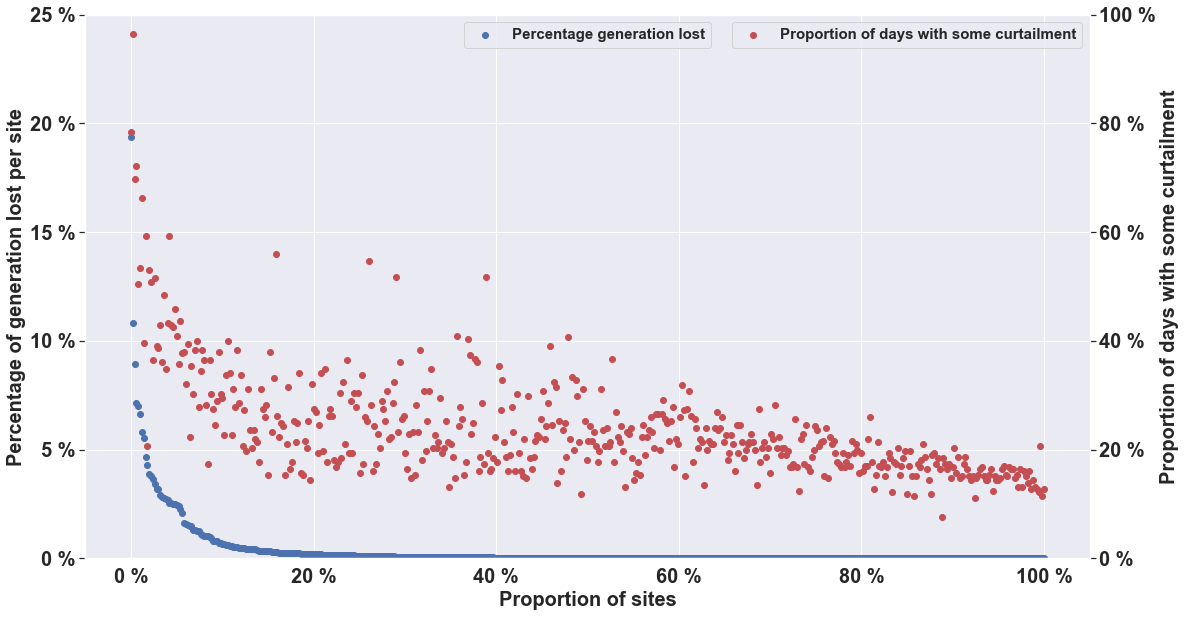

In [229]:
fig, ax1 = plt.subplots()
fig.set_size_inches(18, 10)

ax1.scatter(summary['proportion_of_sites'], summary["percentage_of_generation_lost"], color = 'b', 
            label = 'Percentage generation lost')

ax1.set_xlabel('Proportion of sites', **fontdict)
ax1.set_ylabel('Percentage of generation lost per site', **fontdict)

ax1.set_xticks([0, 20, 40, 60, 80, 100])
ax1.set_xticklabels(['0 %', '20 %', '40 %', '60 %', '80 %', '100 %'], **fontdict)
ax1.set_ylim(0, 25);
ax1.set_yticks([0, 5, 10, 15, 20, 25])
ax1.set_yticklabels(['0 %', '5 %', '10 %', '15 %', '20 %', '25 %'], **fontdict)
ax1.legend(loc = 9, prop={'size': 15})

ax2 = ax1.twinx()
ax2.scatter(summary['proportion_of_sites'], summary['proportion of days with curtailment'], color='r',
           label = 'Proportion of days with some curtailment')
ax2.set_ylabel('Proportion of days with some curtailment', **fontdict)
ax2.set_yticks([0, 20, 40, 60, 80, 100])
ax2.set_yticklabels(['0 %', '20 %', '40 %', '60 %', '80 %', '100 %'], **fontdict)
ax2.set_ylim(0, 100);
ax2.legend(loc = 0, prop={'size': 15})

plt.show()

# UPDATING SPREADSHEET

In [230]:
spreadsheet_before = pd.read_excel(file_path + r'/SolA Curtailment Summary_Final_trippingcsd.xlsx')
#spreadsheet_before.drop(columns = 'Unnamed: 0', inplace = True)

new_data = summary[['c_id', 'total_energy_generation (kWh)', 'total_tripping_curtailment (kWh)']].copy()
new_data.rename(columns={
    "total_energy_generation (kWh)": "total_energy_generation_alldays (kWh)",
    "total_tripping_curtailment (kWh)": "total_tripping_curtailment_alldays (kWh)"}, inplace = True)

spreadsheet_after = pd.merge(spreadsheet_before, new_data, left_on = 'c_id', right_on = 'c_id', how = 'inner')

In [231]:
spreadsheet_after.to_excel(file_path + r'/SolA Curtailment Summary_Final_trippingalldays.xlsx', index = False) 

# MESSY BELOW